In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path='/content/drive/MyDrive/UCI HAR Dataset/UCI HAR Dataset/train'
save_path='/content/drive/MyDrive/UCI HAR Dataset'

In [ ]:
pip install scikeras

In [ ]:
import os
from datetime import datetime
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score

from tensorflow.keras.metrics import Precision, Recall, F1Score
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Input

In [ ]:
class SensorModel:
    def __init__(self, window_size=128, architecture='LSTM'):
        # Model parameters
        self.window_size = window_size
        self.n_features = 6  # acc(x,y,z) + gyro(x,y,z)
        self.n_classes = 6
        self.architecture = architecture
        self.scaler = StandardScaler()

        # Metrics tracking
        self.metrics = ['accuracy', 'loss', 'val_accuracy', 'val_loss']

        # GPU setup
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                print('GPUs Found')
        else:
            print('No gpus found',tf.config.experimental.list_physical_devices())

    def load_data(self, base_path):
        """Load and preprocess sensor data"""
        # Load accelerometer data
        acc_x = np.loadtxt(f"{base_path}/Inertial Signals/body_acc_x_train.txt")
        acc_y = np.loadtxt(f"{base_path}/Inertial Signals/body_acc_y_train.txt")
        acc_z = np.loadtxt(f"{base_path}/Inertial Signals/body_acc_z_train.txt")

        # Load gyroscope data
        gyro_x = np.loadtxt(f"{base_path}/Inertial Signals/body_gyro_x_train.txt")
        gyro_y = np.loadtxt(f"{base_path}/Inertial Signals/body_gyro_y_train.txt")
        gyro_z = np.loadtxt(f"{base_path}/Inertial Signals/body_gyro_z_train.txt")

        # Load labels
        y = np.loadtxt(f"{base_path}/y_train.txt")

        # Combine sensor data
        X = np.dstack([acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z])

        # Normalize features
        X = self.scaler.fit_transform(X.reshape(-1, self.n_features))
        X = X.reshape(-1, self.window_size, self.n_features)

        return X, y

    def create_model(self):
        """Create model based on selected architecture"""
        if self.architecture == 'LSTM':
            model = tf.keras.Sequential([
                tf.keras.layers.LSTM(64, input_shape=(self.window_size, self.n_features),
                                   return_sequences=True),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.LSTM(32),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Dense(32, activation='relu'),
                tf.keras.layers.Dropout(0.3),
                tf.keras.layers.Dense(self.n_classes, activation='softmax')
            ])
        elif self.architecture == 'CNN_LSTM':
            model = tf.keras.Sequential([
                tf.keras.layers.Conv1D(64, 3, activation='relu',
                                     input_shape=(self.window_size, self.n_features)),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv1D(128, 3, activation='relu'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.LSTM(64),
                tf.keras.layers.Dense(32, activation='relu'),
                tf.keras.layers.Dense(self.n_classes, activation='softmax')
            ])
        elif self.architecture == 'CNN_BiLSTM':
            inputs = Input(shape=(self.window_size, self.n_features))

            x = tf.keras.layers.Conv1D(64, 3, activation='relu')(inputs)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Conv1D(128, 3, activation='relu')(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
            x = tf.keras.layers.Dense(32, activation='relu')(x)
            outputs = tf.keras.layers.Dense(self.n_classes, activation='softmax')(x)

            model = tf.keras.Model(inputs=inputs, outputs=outputs)
        elif self.architecture == 'BiLSTM':
            model = tf.keras.Sequential([
                layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(self.window_size, self.n_features)),
                layers.BatchNormalization(),
                layers.Bidirectional(layers.LSTM(32)),
                layers.BatchNormalization(),
                layers.Dense(32, activation='relu'),
                layers.Dropout(0.3),
                layers.Dense(self.n_classes, activation='softmax')
            ])
        elif self.architecture == 'GRU':
            model = tf.keras.Sequential([
                layers.GRU(64, input_shape=(self.window_size, self.n_features), return_sequences=True),
                layers.BatchNormalization(),
                layers.GRU(32),
                layers.BatchNormalization(),
                layers.Dense(32, activation='relu'),
                layers.Dropout(0.3),
                layers.Dense(self.n_classes, activation='softmax')
            ])

        # precision = Precision(name='precision')
        # recall = Recall(name='recall')

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=[
                SparseCategoricalAccuracy(name='accuracy'),
                F1Score()
            ]
        )
        return model
    def train(self, X, y, batch_size=32, epochs=50, validation_data=None):
        """Train model with optional validation data"""
        model = self.create_model()

        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_accuracy',
                patience=5,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                factor=0.5,
                patience=3
            )
        ]

        # Configure training parameters
        train_params = {
            'x': X,
            'y': y-1,  # Adjust labels to start from 0
            'epochs': epochs,
            'batch_size': batch_size,
            'callbacks': callbacks,
            'verbose': 1
        }

        # Add validation data if provided
        if validation_data is not None:
            X_val, y_val = validation_data
            train_params['validation_data'] = (X_val, y_val-1)
        else:
            train_params['validation_split'] = 0.2

        history = model.fit(**train_params)
        self.model = model
        return history

    def train_with_cv(self, X, y, batch_size=32, epochs=50, k_folds=5):
        histories = {}
        best_val_accuracy = 0
        best_model = None

        kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
        y = y - 1  # Convert to 0-based indexing

        for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            model = self.create_model()

            history = model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[
                    tf.keras.callbacks.EarlyStopping(patience=5),
                    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
                ]
            )

            histories[f"fold_{fold+1}"] = history.history

            # Keep track of the best model based on validation accuracy
            val_accuracy = max(history.history['val_accuracy'])
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_model = model

        self.model = best_model
        print(f"\nBest validation Accuracy: {best_val_accuracy:.4f}")

        return histories

    def plot_training_history(self, histories):
        """Plot training metrics"""
        for metric in self.metrics:
            plt.figure(figsize=(12, 6))
            for fold, history in histories.items():
                plt.plot(history[metric], label=f'{fold}')

            plt.title(f'{metric.capitalize()} Over Epochs')
            plt.xlabel('Epoch')
            plt.ylabel(metric.capitalize())
            plt.legend()
            plt.grid(True)
            plt.savefig(f'{self.architecture}_{metric}.png')
            plt.show()
            plt.close()

    def save_model(self, save_dir):
        """
        Save the trained model and scaler to disk

        Parameters:
        -----------
        save_dir : str
            Directory where the model and scaler should be saved
        """
        if not hasattr(self, 'model'):
            raise ValueError("No trained model found. Please train the model first.")

        # Create directory if it doesn't exist
        os.makedirs(save_dir, exist_ok=True)

        # Save the model
        model_path = os.path.join(save_dir, 'sensor_model.h5')
        self.model.save(model_path)

        # Save the scaler
        scaler_path = os.path.join(save_dir, 'scaler.pkl')
        joblib.dump(self.scaler, scaler_path)

        # Save model configuration
        config = {
            'window_size': self.window_size,
            'n_features': self.n_features,
            'n_classes': self.n_classes,
            'architecture': self.architecture
        }
        config_path = os.path.join(save_dir, 'config.pkl')
        joblib.dump(config, config_path)

        print(f"Model saved to {save_dir}")

    @classmethod
    def load_saved_model(cls, model_dir):
        """
        Load a saved model from disk

        Parameters:
        -----------
        model_dir : str
            Directory containing the saved model files

        Returns:
        --------
        SensorModel
            Loaded model instance
        """
        # Load configuration
        config_path = os.path.join(model_dir, 'config.pkl')
        config = joblib.load(config_path)

        # Create model instance
        instance = cls(
            window_size=config['window_size'],
            architecture=config['architecture']
        )

        # Load model
        model_path = os.path.join(model_dir, 'sensor_model.h5')
        instance.model = load_model(model_path)

        # Load scaler
        scaler_path = os.path.join(model_dir, 'scaler.pkl')
        instance.scaler = joblib.load(scaler_path)

        return instance

    def preprocess_raw_data(self, raw_data, sampling_rate=50):
        """
        Preprocess raw sensor data for inference

        Parameters:
        -----------
        raw_data : dict
            Dictionary containing raw sensor data with keys:
            'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z'
            Each key should contain a numpy array of sensor readings
        sampling_rate : int
            Sampling rate of the sensor data in Hz

        Returns:
        --------
        numpy.ndarray
            Preprocessed data ready for inference
        """
        # Check if all required sensors are present
        required_sensors = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']
        if not all(sensor in raw_data for sensor in required_sensors):
            raise ValueError(f"Raw data must contain all sensors: {required_sensors}")

        # Stack all sensor data
        X = np.dstack([raw_data[sensor] for sensor in required_sensors])

        # Create windows with 50% overlap
        stride = self.window_size // 2
        n_samples = ((X.shape[0] - self.window_size) // stride) + 1
        windows = np.zeros((n_samples, self.window_size, self.n_features))

        for i in range(n_samples):
            start_idx = i * stride
            windows[i] = X[start_idx:start_idx + self.window_size]

        # Reshape for scaling
        X_scaled = self.scaler.transform(windows.reshape(-1, self.n_features))
        X_scaled = X_scaled.reshape(-1, self.window_size, self.n_features)

        return X_scaled

    def predict_activity(self, raw_data, sampling_rate=50):
        """
        Predict activity from raw sensor data

        Parameters:
        -----------
        raw_data : dict
            Dictionary containing raw sensor data with keys:
            'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z'
            Each key should contain a numpy array of sensor readings
        sampling_rate : int
            Sampling rate of the sensor data in Hz

        Returns:
        --------
        tuple
            (predictions, probabilities)
            predictions: array of predicted activity labels
            probabilities: array of prediction probabilities for each class
        """
        if not hasattr(self, 'model'):
            raise ValueError("No trained model found. Please train or load a model first.")

        # Preprocess the raw data
        X_processed = self.preprocess_raw_data(raw_data, sampling_rate)

        # Get predictions
        probabilities = self.model.predict(X_processed)
        predictions = np.argmax(probabilities, axis=1) + 1  # Add 1 to match original labels

        return predictions, probabilities

In [ ]:
model.save_model(f'{save_path}/saved_models/{model.architecture}')

Model saved to /content/drive/MyDrive/UCI HAR Dataset/saved_models/CNN_BiLSTM


No gpus found [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

Fold 1/2
train_idx: [   1    2    3 ... 7347 7348 7349]
val_idx: [   0    8   12 ... 7346 7350 7351]
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


115/115 ━━━━━━━━━━━━━━━━━━━━ 32s 216ms/step - accuracy: 0.4827 - loss: 1.2220 - val_accuracy: 0.6140 - val_loss: 0.7035 - learning_rate: 0.0010
Epoch 2/2
115/115 ━━━━━━━━━━━━━━━━━━━━ 41s 217ms/step - accuracy: 0.6632 - loss: 0.6300 - val_accuracy: 0.6665 - val_loss: 0.6035 - learning_rate: 0.0010

Fold 2/2
train_idx: [   0    8   12 ... 7346 7350 7351]
val_idx: [   1    2    3 ... 7347 7348 7349]
Epoch 1/2
115/115 ━━━━━━━━━━━━━━━━━━━━ 33s 220ms/step - accuracy: 0.4328 - loss: 1.1931 - val_accuracy: 0.6314 - val_loss: 0.7147 - learning_rate: 0.0010
Epoch 2/2
115/115 ━━━━━━━━━━━━━━━━━━━━ 25s 217ms/step - accuracy: 0.6522 - loss: 0.6400 - val_accuracy: 0.6352 - val_loss: 0.6372 - learning_rate: 0.0010


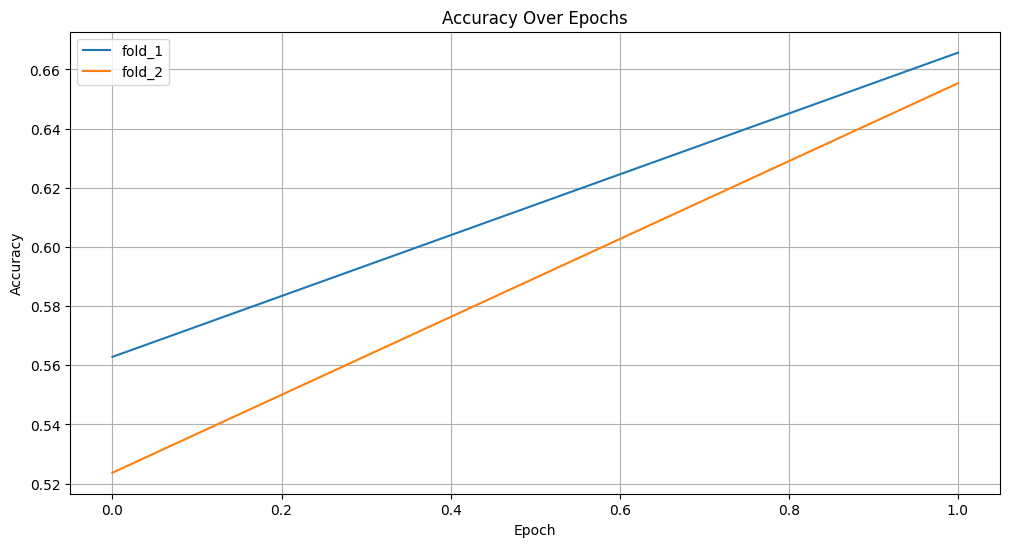

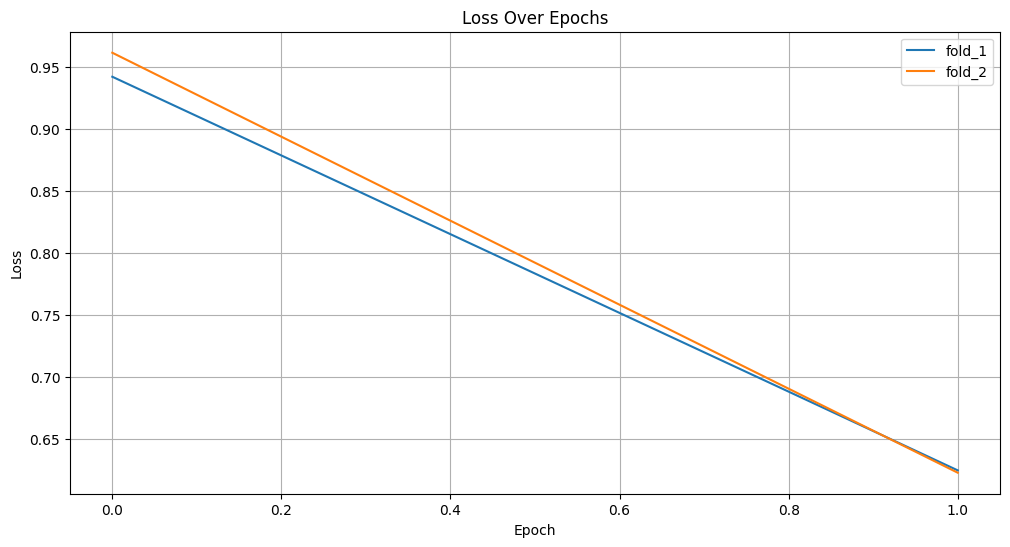

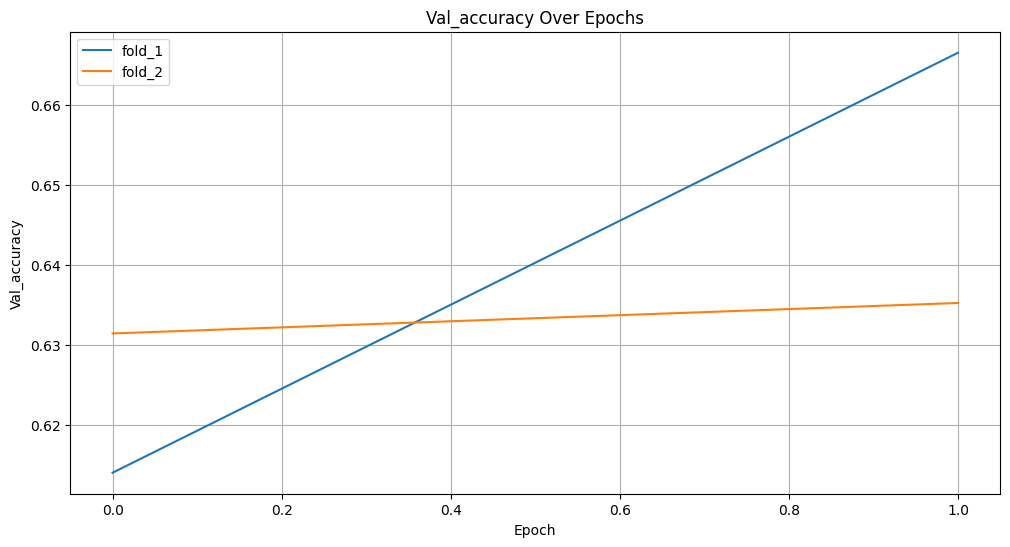

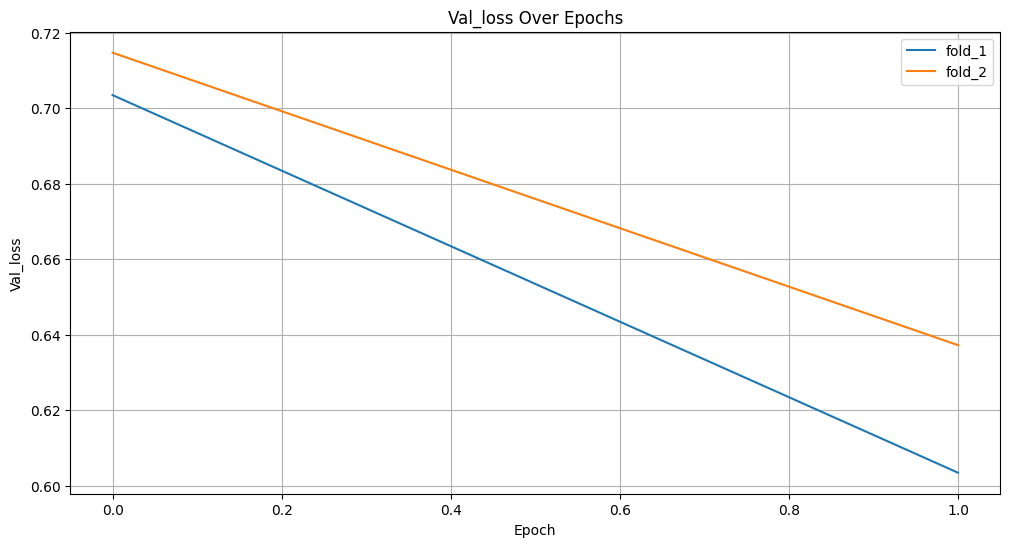

ValueError: No trained model found. Please train the model first.

In [ ]:
# Training and saving the model
model = SensorModel(window_size=128, architecture='CNN_BiLSTM')
X_train, y_train = model.load_data(base_path)
histories = model.train_with_cv(X_train, y_train, batch_size=32, epochs=2, k_folds=2)
model.save_model(f'{save_path}/saved_models/my_model')

In [ ]:
# Loading the saved model and running inference
loaded_model = SensorModel.load_saved_model(f'{save_path}/saved_models/my_model')

# Example raw data (simulated here)
raw_data = {
    'acc_x': np.random.random(1000),  # 20 seconds of data at 50Hz
    'acc_y': np.random.random(1000),
    'acc_z': np.random.random(1000),
    'gyro_x': np.random.random(1000),
    'gyro_y': np.random.random(1000),
    'gyro_z': np.random.random(1000)
}

# Run inference
predictions, probabilities = loaded_model.predict_activity(raw_data)
print("Predicted activities:", predictions)
print("Prediction probabilities:", probabilities)

In [ ]:
model = SensorModel(window_size=128, architecture='CNN_LSTM')
X_train, y_train = model.load_data(base_path)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
histories = model.train_with_cv(X_train, y_train, batch_size=32, epochs=50,k_folds=5)

GPUs Found
y shape: (7352,)
X_train shape: (7352, 128, 6)
y_train shape: (7352,)

Fold 1/5
train_idx: [   1    2    3 ... 7349 7350 7351]
val_idx: [   0    8   14 ... 7342 7343 7345]
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


KeyboardInterrupt: 

In [ ]:
model = SensorModel(window_size=128, architecture='CNN_BiLSTM')
X_train, y_train = model.load_data(base_path)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
histories = model.train_with_cv(X_train, y_train, batch_size=32, epochs=50, k_folds=5)

In [ ]:
import pickle
with open(f'{model.architecture}_model_window_{model.window_size}.pkl', 'wb') as f:
    pickle.dump(model.model, f)

AttributeError: 'SensorModel' object has no attribute 'model'

In [ ]:
model = SensorModel(window_size=128, architecture='CNN_LSTM')
X_train, y_train = model.load_data(base_path)
histories = model.train_with_cv(X_train, y_train, batch_size=32, epochs=50,k_folds=5)

GPUs Found

Fold 1/5


NameError: name 'time' is not defined


Fold 1/5
Epoch 1/50


C:\Users\imkha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


184/184 ━━━━━━━━━━━━━━━━━━━━ 27s 131ms/step - accuracy: 0.3587 - loss: 1.5095 - val_accuracy: 0.5391 - val_loss: 1.0595 - learning_rate: 0.0010
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 24s 130ms/step - accuracy: 0.5723 - loss: 0.8257 - val_accuracy: 0.6349 - val_loss: 0.6487 - learning_rate: 0.0010
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.6269 - loss: 0.7013 - val_accuracy: 0.6356 - val_loss: 0.6365 - learning_rate: 0.0010
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 24s 132ms/step - accuracy: 0.6380 - loss: 0.6592 - val_accuracy: 0.6363 - val_loss: 0.6585 - learning_rate: 0.0010
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 26s 140ms/step - accuracy: 0.6471 - loss: 0.6349 - val_accuracy: 0.5874 - val_loss: 0.8398 - learning_rate: 0.0010
Epoch 6/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 26s 140ms/step - accuracy: 0.6338 - loss: 0.6535 - val_accuracy: 0.6234 - val_loss: 0.6098 - learning_rate: 0.0010
Epoch 7/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 26s 139ms/step - accuracy: 0.6353 - loss:

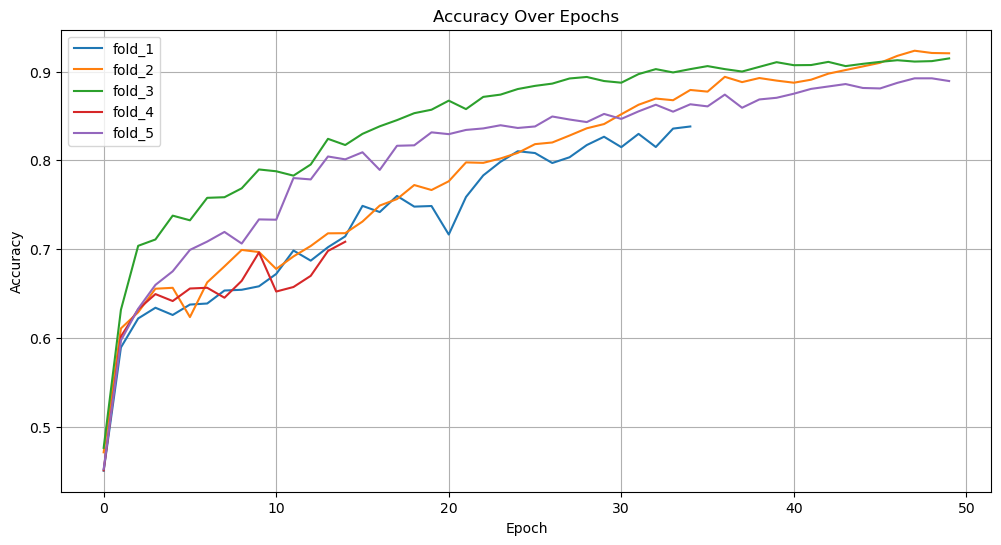

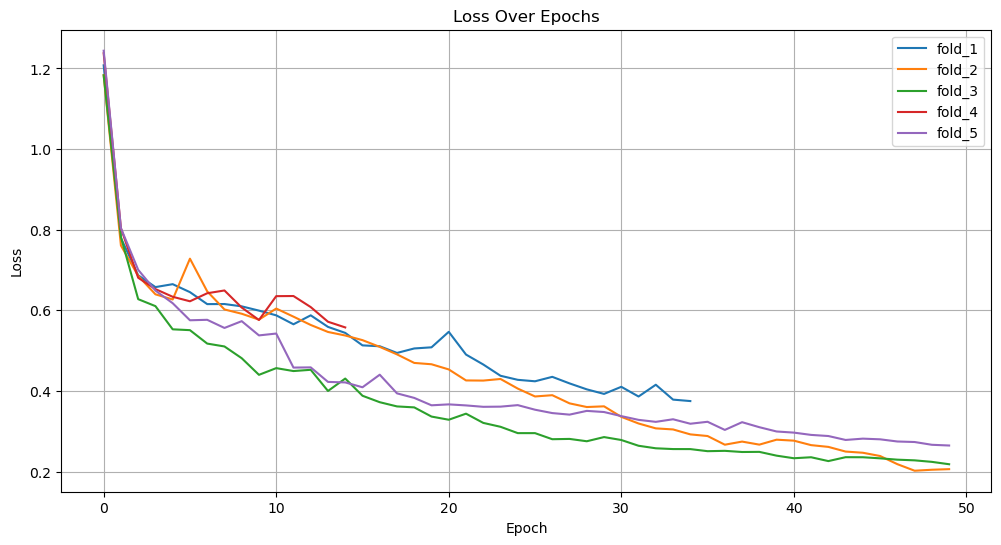

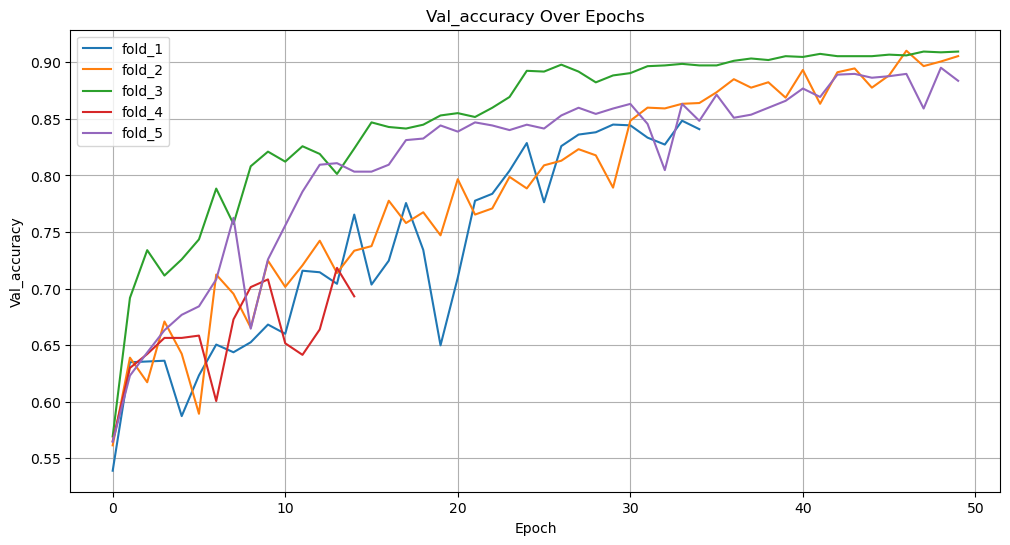

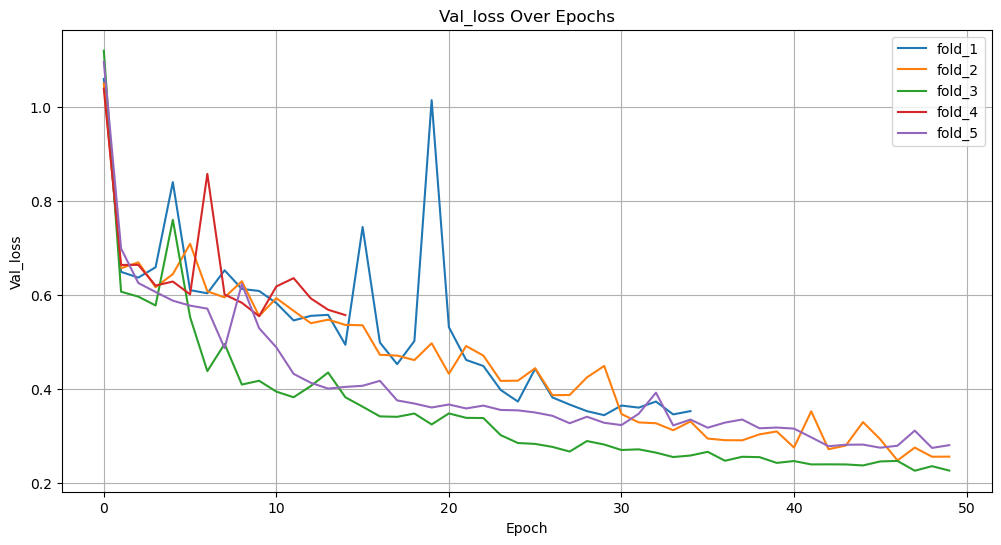

In [ ]:
model = SensorModel(window_size=128, architecture='LSTM')
X_train, y_train = model.load_data("C:/Users/imkha/Desktop/100 days of code/sensor_har/UCI HAR Dataset/train")
histories = model.train_with_cv(X_train, y_train, batch_size=32, epochs=50,k_folds=5)

In [ ]:
model = SensorModel(window_size=128, architecture='BiLSTM')
X_train, y_train = model.load_data(base_path)
histories = model.train_with_cv(X_train, y_train, batch_size=32, epochs=50,k_folds=5)

GPUs Found

Fold 1/5
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.4141 - loss: 1.3767 - val_accuracy: 0.6125 - val_loss: 1.0537 - learning_rate: 0.0010
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.6316 - loss: 0.7447 - val_accuracy: 0.6859 - val_loss: 0.6111 - learning_rate: 0.0010
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.6858 - loss: 0.6271 - val_accuracy: 0.7084 - val_loss: 0.5621 - learning_rate: 0.0010
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.7073 - loss: 0.5719 - val_accuracy: 0.7689 - val_loss: 0.4989 - learning_rate: 0.0010
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7543 - loss: 0.5146 - val_accuracy: 0.7729 - val_loss: 0.4737 - learning_rate: 0.0010
Epoch 6/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.7697 - loss: 0.4731 - val_accuracy: 0.7192 - val_loss: 0.5308 - learning_rate: 0.0010
Epoch 7/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.7298 - loss: 0.5316 - val

KeyboardInterrupt: 

GPUs Found

Fold 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.3280 - loss: 1.5646 - val_accuracy: 0.4636 - val_loss: 1.1555 - learning_rate: 0.0010
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5387 - loss: 0.9466 - val_accuracy: 0.5955 - val_loss: 0.7471 - learning_rate: 0.0010
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6132 - loss: 0.7376 - val_accuracy: 0.6077 - val_loss: 0.6508 - learning_rate: 0.0010
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6226 - loss: 0.6784 - val_accuracy: 0.6254 - val_loss: 0.6308 - learning_rate: 0.0010
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6285 - loss: 0.6664 - val_accuracy: 0.6377 - val_loss: 0.6246 - learning_rate: 0.0010
Epoch 6/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6444 - loss: 0.6222 - val_accuracy: 0.6383 - val_loss: 0.6253 - learning_rate: 0.0010
Epoch 7/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6514 - loss: 0.

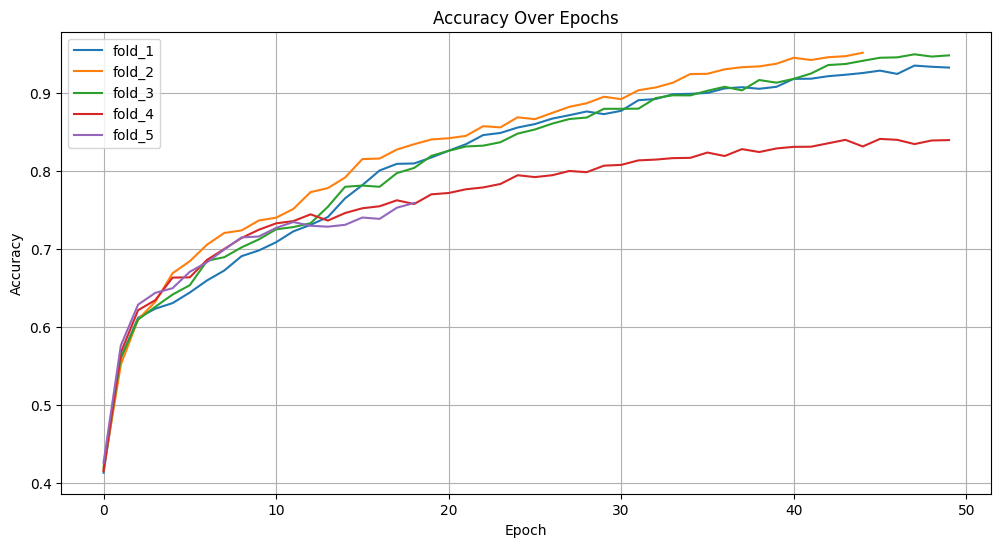

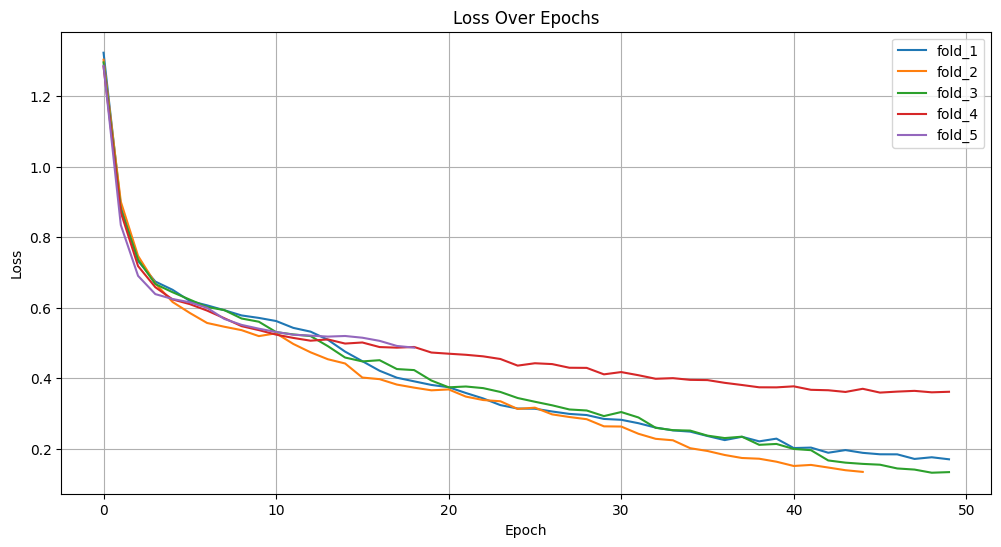

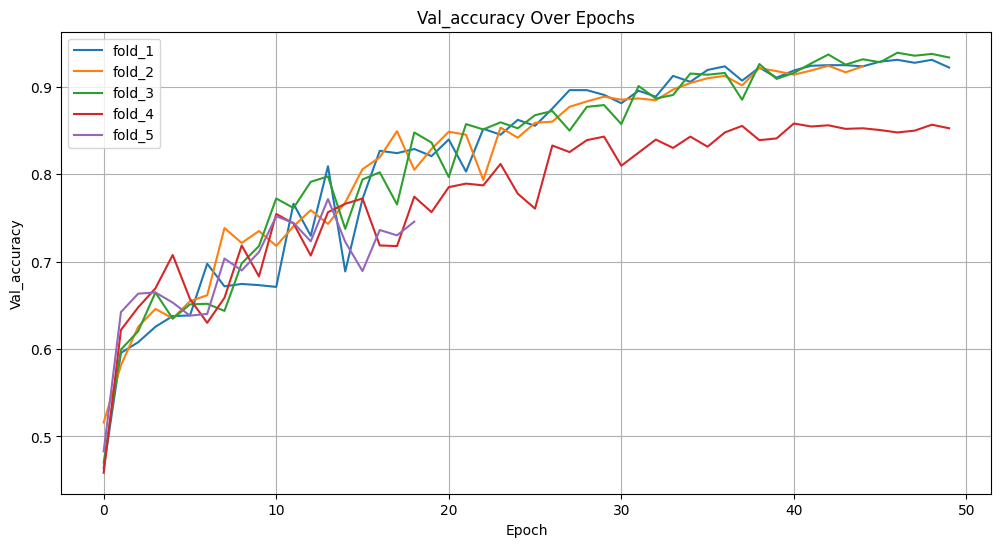

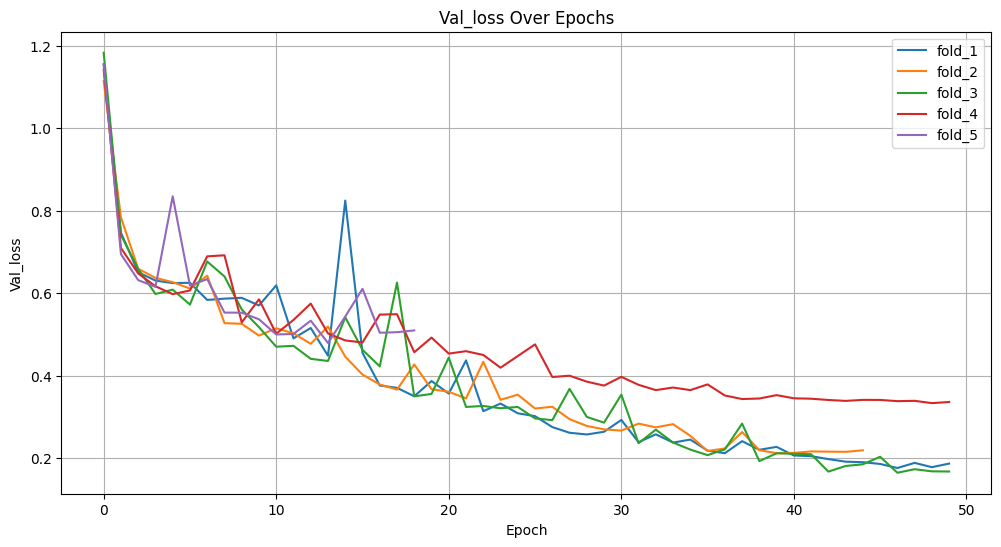

In [ ]:
model = SensorModel(window_size=128, architecture='GRU')
X_train, y_train = model.load_data(base_path)
histories = model.train_with_cv(X_train, y_train, batch_size=32, epochs=50,k_folds=5)

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from datetime import datetime
import os

class ModelComparison:
    def __init__(self, save_dir='model_comparison', k_folds=5):
        self.save_dir = save_dir
        self.timestamp = datetime.now().strftime('%Y%m%d_%H%M')
        os.makedirs(save_dir, exist_ok=True)

        self.k_folds = k_folds
        self.metrics = ['accuracy', 'loss', 'val_accuracy', 'val_loss']
        self.architectures = ['LSTM', 'BiLSTM', 'GRU', 'CNN_LSTM']
        self.cv_results = {arch: {} for arch in self.architectures}

    def _pad_histories(self, histories):
        # Find max length
        max_len = max(len(h['loss']) for h in histories)

        # Pad each history to max length
        padded = []
        for h in histories:
            pad_hist = {}
            for metric in self.metrics:
                curr_len = len(h[metric])
                if curr_len < max_len:
                    # Pad with last value
                    pad_hist[metric] = np.pad(h[metric],
                                            (0, max_len - curr_len),
                                            'edge')
                else:
                    pad_hist[metric] = h[metric]
            padded.append(pad_hist)
        return padded

    def _average_fold_metrics(self, fold_histories):
        # Pad histories to same length
        padded_histories = self._pad_histories(fold_histories)

        # Calculate averages
        avg_history = {}
        for metric in self.metrics:
            values = np.array([h[metric] for h in padded_histories])
            avg_history[metric] = np.mean(values, axis=0)
            avg_history[f'{metric}_std'] = np.std(values, axis=0)
        return avg_history

    def plot_cv_comparisons(self):
        for metric in self.metrics:
            plt.figure(figsize=(12, 6))

            for arch in self.architectures:
                if arch not in self.cv_results:
                    continue

                history = self.cv_results[arch]
                if not history:
                    continue

                mean_values = history[metric]
                std_values = history[f'{metric}_std']
                epochs = range(1, len(mean_values) + 1)

                plt.plot(epochs, mean_values, label=arch)
                plt.fill_between(epochs,
                               mean_values - std_values,
                               mean_values + std_values,
                               alpha=0.2)

            plt.title(f'Cross-validated {metric.capitalize()}')
            plt.xlabel('Epoch')
            plt.ylabel(metric.capitalize())
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.savefig(f'{self.save_dir}/cv_{metric}_{self.timestamp}.png')
            plt.close()

    def compare_models(self, X, y, window_size=128, batch_size=32, epochs=50):
        kf = KFold(n_splits=self.k_folds, shuffle=True, random_state=42)

        for arch in self.architectures:
            print(f"\nTraining {arch} model...")
            fold_histories = []

            for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
                print(f"Fold {fold+1}/{self.k_folds}")
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]

                model = SensorModel(window_size=window_size, architecture=arch)
                history = model.train(X_train, y_train,
                                    validation_data=(X_val, y_val),
                                    batch_size=batch_size,
                                    epochs=epochs)
                fold_histories.append(history.history)

            # Calculate average metrics across folds
            self.cv_results[arch] = self._average_fold_metrics(fold_histories)

        self.plot_cv_comparisons()
        self.save_cv_results()

    def save_cv_results(self):
        results_dict = {
            'Architecture': [],
            'Final Val Accuracy (mean)': [],
            'Final Val Accuracy (std)': [],
            'Best Val Accuracy': [],
            'Final Val Loss (mean)': [],
            'Final Val Loss (std)': []
        }

        for arch in self.architectures:
            history = self.cv_results[arch]
            results_dict['Architecture'].append(arch)
            results_dict['Final Val Accuracy (mean)'].append(history['val_accuracy'][-1])
            results_dict['Final Val Accuracy (std)'].append(history['val_accuracy_std'][-1])
            results_dict['Best Val Accuracy'].append(np.max(history['val_accuracy']))
            results_dict['Final Val Loss (mean)'].append(history['val_loss'][-1])
            results_dict['Final Val Loss (std)'].append(history['val_loss_std'][-1])

        pd.DataFrame(results_dict).to_csv(
            f'{self.save_dir}/cv_results_{self.timestamp}.csv',
            index=False
        )

In [ ]:
# Usage
import time
init_time=time.time()
model = SensorModel(window_size=128)
X_train, y_train = model.load_data(base_path)
comparison = ModelComparison(k_folds=5)
comparison.compare_models(X_train, y_train, window_size=128, batch_size=32, epochs=50)
print(f'Time taken:{time.time()-init_time}')

GPUs Found

Training LSTM model...
Fold 1/5
GPUs Found
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.3694 - loss: 1.4941 - val_accuracy: 0.5486 - val_loss: 1.0177 - learning_rate: 0.0010
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5754 - loss: 0.8407 - val_accuracy: 0.6193 - val_loss: 0.6786 - learning_rate: 0.0010
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6247 - loss: 0.6838 - val_accuracy: 0.6234 - val_loss: 0.6722 - learning_rate: 0.0010
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6448 - loss: 0.6499 - val_accuracy: 0.6424 - val_loss: 0.6418 - learning_rate: 0.0010
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.6182 - loss: 0.6709 - val_accuracy: 0.6356 - val_loss: 0.6452 - learning_rate: 0.0010
Epoch 6/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6440 - loss: 0.6350 - val_accuracy: 0.6533 - val_loss: 0.6098 - learning_rate: 0.0010
Epoch 7/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6341 - loss: 0.6316 - val_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


184/184 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.4174 - loss: 1.4279 - val_accuracy: 0.6016 - val_loss: 1.1030 - learning_rate: 0.0010
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6264 - loss: 0.7904 - val_accuracy: 0.6825 - val_loss: 0.6510 - learning_rate: 0.0010
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6686 - loss: 0.6699 - val_accuracy: 0.6975 - val_loss: 0.5763 - learning_rate: 0.0010
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.7147 - loss: 0.6091 - val_accuracy: 0.7145 - val_loss: 0.5308 - learning_rate: 0.0010
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.7404 - loss: 0.5309 - val_accuracy: 0.7614 - val_loss: 0.4829 - learning_rate: 0.0010
Epoch 6/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.7711 - loss: 0.5025 - val_accuracy: 0.7784 - val_loss: 0.4537 - learning_rate: 0.0010
Epoch 7/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.7719 - loss: 0.4861 - val

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


184/184 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.4751 - loss: 1.1188 - val_accuracy: 0.6390 - val_loss: 0.6400 - learning_rate: 0.0010
Epoch 2/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6445 - loss: 0.6487 - val_accuracy: 0.6295 - val_loss: 0.6592 - learning_rate: 0.0010
Epoch 3/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.6593 - loss: 0.6267 - val_accuracy: 0.6553 - val_loss: 0.6192 - learning_rate: 0.0010
Epoch 4/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.6831 - loss: 0.6032 - val_accuracy: 0.6778 - val_loss: 0.5789 - learning_rate: 0.0010
Epoch 5/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.7175 - loss: 0.5690 - val_accuracy: 0.6812 - val_loss: 0.5742 - learning_rate: 0.0010
Epoch 6/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7100 - loss: 0.5562 - val_accuracy: 0.7022 - val_loss: 0.5729 - learning_rate: 0.0010
Epoch 7/50
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7609 - loss: 0.4878 - val_